In [ ]:
"""
Hyformer + Gumbeldore sampling with Incremental SBS.
"""

%load_ext autoreload
%autoreload 2

import os
import sys
from typing import Callable, List, Tuple, Optional

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from joint_improvement.generators import GumbeldoreMixinV1

from joint_improvement.utils.chemistry import calculate_validity, calculate_logp


In [ ]:
# auxiliary imports

# from hyformer.utils import create_dataloader

def build_hyformer_tokenizer(
    tokenizer_config_path: str,
     version: str
     ) -> "Tokenizer":
    if version == "v1":
        from hyformer.configs.tokenizer import TokenizerConfig
        from hyformer import AutoTokenizer        
        tokenizer_config = TokenizerConfig.from_config_file(tokenizer_config_path)
        tokenizer = AutoTokenizer.from_config(tokenizer_config)
        return tokenizer
    if version == "v2":
        raise NotImplementedError("Tokenizer v2 not implemented")
    else:
        raise ValueError(f"Invalid tokenizer version: {version}. Available versions: v1, v2")


def build_hyformer_model(
    model_config_path: str,
    model_ckpt_path: str = None,
    device: torch.device = None,
    sampler: str = None,
    num_tasks: int = 1,
    downstream_task: str = "regression"
    ):
    """ Legacy wrapper for Hyformer model with Gumbeldore sampling.
    """
    from hyformer.configs import ModelConfig
    if sampler == "gumbeldore_v1":
        from hyformer.models.hyformer import HyformerForDownstreamPrediction
        from src.joint_improvement.generators.gumbeldore import GumbeldoreMixinV1
        class HyformerSampler(GumbeldoreMixinV1, HyformerForDownstreamPrediction):
            """ MRO priorizites `generate` method from `GumbeldoreMixinV1`. """
            pass
    elif sampler == "gumbeldore_v2":
        from src.joint_improvement.generators.gumbeldore import GumbeldoreMixinV2
        class HyformerSampler(GumbeldoreMixinV2, HyformerForDownstreamPrediction):
            """ MRO priorizites `generate` method from `GumbeldoreMixinV2`. """
            pass
    else:
        raise ValueError(f"Invalid sampler: {sampler}. Available samplers: gumbeldore_v1, gumbeldore_v2")
      
    model_config = ModelConfig.from_config_file(model_config_path)
    model = HyformerSampler.from_config(
        model_config,
        num_tasks=num_tasks,
        downstream_task=downstream_task
    )
    if model_ckpt_path is not None:
        model.load_pretrained(model_ckpt_path)
    if device is not None:
        model.to(device)
    return model


In [ ]:
tokenizer = build_hyformer_tokenizer("configs/legacy/smiles/tokenizer_config.json", version="v1")

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/home/adamizdebski/projects/joint-improvement/Y/envs/joint-improvement/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped

In [ ]:
model = build_hyformer_model(
    model_config_path="configs/legacy/smiles/model_config.json", 
    model_ckpt_path="configs/legacy/smiles/ckpt.pt",
    sampler="gumbeldore_v1"
    )

Model state_dict loaded with strict=True.


In [ ]:
prefix_input_ids = torch.tensor(tokenizer.generation_prefix, dtype=torch.long)

In [ ]:
def oracle_fn(input_idx: torch.Tensor, tokenizer: "Tokenizer") -> List[float]:
    smiles = tokenizer.decode(input_idx.unsqueeze(0))[0]
    is_valid = calculate_validity(smiles)
    if is_valid:
        return calculate_logp(smiles)
    else:
        return -100.0

from functools import partial
oracle = partial(oracle_fn, tokenizer=tokenizer)

In [ ]:
def advantage_fn(prediction: float) -> float:
    return (prediction - 5.0) ** 2


In [ ]:
beam_width = 64
num_rounds = 10

samples = model.generate(
    prefix_input_ids=prefix_input_ids,
    advantage_fn=lambda x: x,
    oracle_fn=None,
    max_sequence_length=128,
    eos_token_id=591,
    advantage_constant=2.0,
    beam_width=beam_width,
    num_rounds=num_rounds
    )


In [ ]:
smiles = tokenizer.decode(samples)
print(f"Validity: {len([smile for smile in smiles if calculate_validity(smile)])/len(smiles):.3f}")

smiles_valid = [smile for smile in smiles if calculate_validity(smile)]
target_values = [calculate_logp(smile) for smile in smiles_valid]


Validity: 0.641


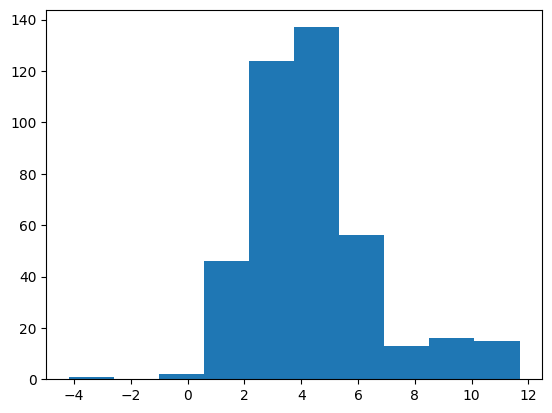

Mean: 4.402
Median: 4.012
Standard Deviation: 2.246
Minimum: -4.192
Maximum: 11.688


In [ ]:
# plot histogram of target values

import matplotlib.pyplot as plt
plt.hist(target_values, bins=10)
plt.show()

# print descriptive statistics
print(f"Mean: {np.mean(target_values):.3f}")
print(f"Median: {np.median(target_values):.3f}")
print(f"Standard Deviation: {np.std(target_values):.3f}")
print(f"Minimum: {np.min(target_values):.3f}")
print(f"Maximum: {np.max(target_values):.3f}")




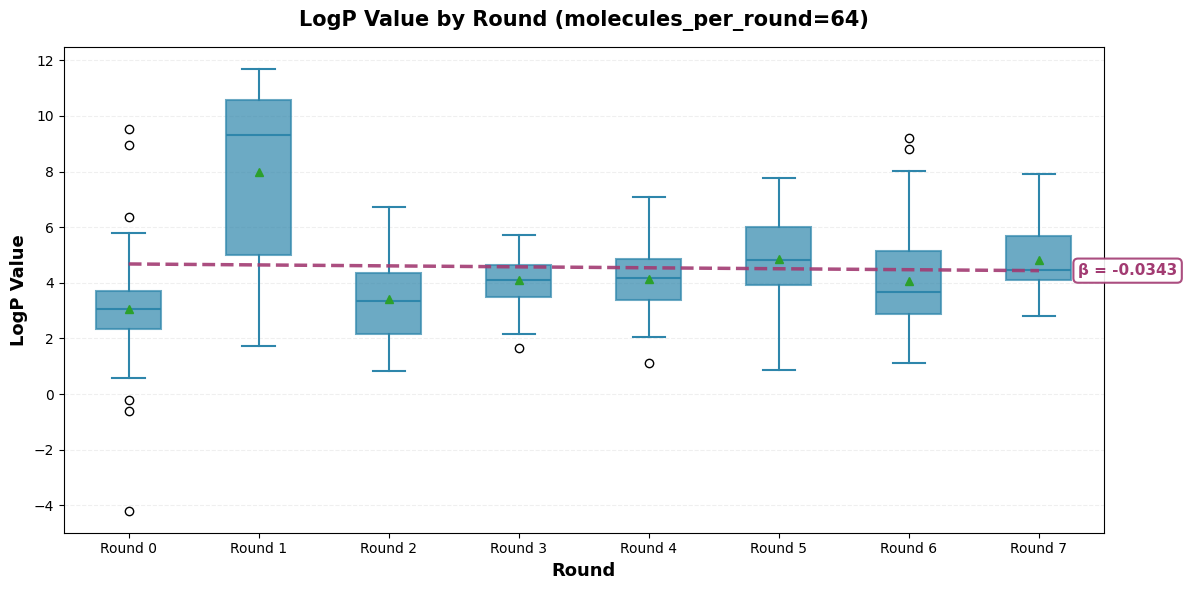


Overall Validity: 0.641
Total SMILES: 640
Valid SMILES: 410

Statistics by Round:
------------------------------------------------------------
Round 0:
  Validity: 0.953 (61/64)
  Count: 61
  Mean: 3.058
  Median: 3.043
  Std: 1.931
  Min: -4.192
  Max: 9.524

Round 1:
  Validity: 0.688 (44/64)
  Count: 44
  Mean: 7.985
  Median: 9.327
  Std: 3.149
  Min: 1.711
  Max: 11.688

Round 2:
  Validity: 0.969 (62/64)
  Count: 62
  Mean: 3.407
  Median: 3.357
  Std: 1.476
  Min: 0.812
  Max: 6.714

Round 3:
  Validity: 0.734 (47/64)
  Count: 47
  Mean: 4.118
  Median: 4.090
  Std: 0.908
  Min: 1.659
  Max: 5.712

Round 4:
  Validity: 0.922 (59/64)
  Count: 59
  Mean: 4.148
  Median: 4.155
  Std: 1.138
  Min: 1.112
  Max: 7.078

Round 5:
  Validity: 0.953 (61/64)
  Count: 61
  Mean: 4.837
  Median: 4.830
  Std: 1.582
  Min: 0.855
  Max: 7.778

Round 6:
  Validity: 0.922 (59/64)
  Count: 59
  Mean: 4.073
  Median: 3.674
  Std: 1.884
  Min: 1.125
  Max: 9.206

Round 7:
  Validity: 0.266 (17/64)


In [ ]:
from typing import Dict, List


def _group_smiles_by_round(smiles: List[str], num_molecules_per_round: int) -> Tuple[List[int], Dict[int, List[str]]]:
    """Group SMILES strings by round and return round indices."""
    num_rounds = len(smiles) // num_molecules_per_round
    round_indices = [round_idx for round_idx in range(num_rounds) 
                     for _ in range(num_molecules_per_round)][:len(smiles)]
    
    smiles_by_round = {round_idx: [] for round_idx in range(num_rounds)}
    for smile, round_idx in zip(smiles, round_indices):
        smiles_by_round[round_idx].append(smile)
    
    return round_indices, smiles_by_round


def _calculate_validity_fractions(smiles_by_round: Dict[int, List[str]]) -> Dict[int, float]:
    """Calculate validity fraction for each round."""
    validity_fractions = {}
    for round_idx, round_smiles in smiles_by_round.items():
        if len(round_smiles) > 0:
            valid_count = sum(1 for s in round_smiles if calculate_validity(s))
            total_count = len(round_smiles)
            validity_fractions[round_idx] = valid_count / total_count
        else:
            validity_fractions[round_idx] = np.nan
    return validity_fractions


def _extract_target_values(smiles: List[str], round_indices: List[int], 
                           target_fn: Callable[[str], float]) -> Tuple[np.ndarray, np.ndarray]:
    """Extract target values for valid SMILES and their round indices."""
    target_values = []
    valid_round_indices = []
    
    for smile, round_idx in zip(smiles, round_indices):
        if calculate_validity(smile):
            target_values.append(target_fn(smile))
            valid_round_indices.append(round_idx)
    
    return np.array(target_values), np.array(valid_round_indices)


def _group_targets_by_round(target_values: np.ndarray, valid_round_indices: np.ndarray, 
                            num_rounds: int) -> Tuple[Dict[int, np.ndarray], Dict[int, float]]:
    """Group target values by round and calculate means."""
    round_data = {}
    round_means = {}
    
    for round_idx in range(num_rounds):
        round_mask = valid_round_indices == round_idx
        if np.any(round_mask):
            round_data[round_idx] = target_values[round_mask]
            round_means[round_idx] = np.mean(round_data[round_idx])
        else:
            round_means[round_idx] = np.nan
    
    return round_data, round_means


def _fit_trend_line(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    """Fit a linear trend line and return the line and slope coefficient."""
    if len(y) < 2:
        return np.array([]), 0.0
    coeffs = np.polyfit(x, y, 1)
    trend_line = np.poly1d(coeffs)(x)
    return trend_line, coeffs[0]


def _add_trend_annotation(ax, x_pos: float, y_pos: float, slope: float, color: str):
    """Add a trend coefficient annotation to the plot."""
    text = f'β = {slope:.4f}'
    ax.text(x_pos, y_pos, text, fontsize=11, color=color, fontweight='bold',
            verticalalignment='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor=color, linewidth=1.5, alpha=0.9))


def _calculate_zoomed_ylim(values: np.ndarray, padding: float = 0.05) -> Tuple[float, float]:
    """Calculate zoomed y-axis limits with padding."""
    if len(values) == 0:
        return 0.0, 1.0
    
    v_min, v_max = np.nanmin(values), np.nanmax(values)
    v_range = v_max - v_min
    
    if v_range < 0.1:
        y_min = max(0, v_min - padding)
        y_max = min(1, v_max + padding)
    else:
        y_min = max(0, v_min - padding * v_range)
        y_max = min(1, v_max + padding * v_range)
    
    return y_min, y_max


def plot_target_values_by_round(
    smiles: List[str],
    num_molecules_per_round: int,
    target_fn: Callable[[str], float],
    target_label: str = "Target Value",
    title: Optional[str] = None
) -> None:
    """
    Plot target values grouped by rounds with box plots, trend line, and validity fraction.
    
    Parameters
    ----------
    smiles : List[str]
        List of SMILES strings, ordered by rounds (num_molecules_per_round per round)
    num_molecules_per_round : int
        Number of molecules generated per round (beam_width)
    target_fn : Callable[[str], float]
        Function that takes a SMILES string and returns a target value (e.g., calculate_logp)
    target_label : str, optional
        Label for the target value axis (default: "Target Value")
    title : str, optional
        Plot title (default: auto-generated)
    """
    import matplotlib.pyplot as plt
    
    # Data processing
    round_indices, smiles_by_round = _group_smiles_by_round(smiles, num_molecules_per_round)
    validity_fractions_dict = _calculate_validity_fractions(smiles_by_round)
    target_values, valid_round_indices = _extract_target_values(smiles, round_indices, target_fn)
    
    num_rounds = len(smiles_by_round)
    round_data, round_means = _group_targets_by_round(target_values, valid_round_indices, num_rounds)
    
    # Publication-ready color palette (colorblind-friendly)
    colors = {
        'box': '#2E86AB',
        'target_trend': '#A23B72'
    }
    
    # Prepare plotting data
    round_numbers = sorted(round_data.keys())
    round_values = [round_data[r] for r in round_numbers]
    round_labels = [f'Round {r}' for r in round_numbers]
    x_positions = np.array(range(len(round_numbers)))
    mean_values = np.array([round_means[r] for r in round_numbers])
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot box plots
    box_plot = ax.boxplot(round_values, positions=x_positions, tick_labels=round_labels,
                          patch_artist=True, showmeans=True)
    for patch in box_plot['boxes']:
        patch.set_facecolor(colors['box'])
        patch.set_alpha(0.7)
        patch.set_edgecolor(colors['box'])
        patch.set_linewidth(1.5)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element in box_plot:
            plt.setp(box_plot[element], color=colors['box'], linewidth=1.5)
    
    # Plot target trend line
    target_trend_line, target_slope = _fit_trend_line(x_positions, mean_values)
    if len(target_trend_line) > 0:
        ax.plot(x_positions, target_trend_line, '--', color=colors['target_trend'],
                linewidth=2.5, alpha=0.9, zorder=10)
        _add_trend_annotation(ax, x_positions[-1] + 0.3, target_trend_line[-1],
                              target_slope, colors['target_trend'])
    
    # Configure main axis
    ax.set_xlabel('Round', fontsize=13, fontweight='bold', color='black')
    ax.set_ylabel(target_label, fontsize=13, fontweight='bold', color='black')
    ax.tick_params(axis='both', colors='black')
    if title is None:
        title = f'{target_label} by Round (molecules_per_round={num_molecules_per_round})'
    ax.set_title(title, fontsize=15, fontweight='bold', pad=15, color='black')
    ax.grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print overall validity for comparison
    overall_validity = len([s for s in smiles if calculate_validity(s)]) / len(smiles) if len(smiles) > 0 else 0.0
    print(f"\nOverall Validity: {overall_validity:.3f}")
    print(f"Total SMILES: {len(smiles)}")
    print(f"Valid SMILES: {len([s for s in smiles if calculate_validity(s)])}")
    
    # Print statistics - include all rounds with smiles
    all_rounds_with_smiles = sorted([r for r in validity_fractions_dict.keys() 
                                     if not np.isnan(validity_fractions_dict[r])])
    print("\nStatistics by Round:")
    print("-" * 60)
    for round_idx in all_rounds_with_smiles:
        validity_frac = validity_fractions_dict[round_idx]
        validity_str = f"{validity_frac:.3f}" if not np.isnan(validity_frac) else "N/A"
        
        # Get round info for debugging
        round_smiles = smiles_by_round.get(round_idx, [])
        round_valid_count = sum(1 for s in round_smiles if calculate_validity(s))
        round_total_count = len(round_smiles)
        
        print(f"Round {round_idx}:")
        print(f"  Validity: {validity_str} ({round_valid_count}/{round_total_count})")
        
        if round_idx in round_data:
            values = round_data[round_idx]
            print(f"  Count: {len(values)}")
            print(f"  Mean: {np.mean(values):.3f}")
            print(f"  Median: {np.median(values):.3f}")
            print(f"  Std: {np.std(values):.3f}")
            print(f"  Min: {np.min(values):.3f}")
            print(f"  Max: {np.max(values):.3f}")
        else:
            print(f"  Count: 0 (no valid target values)")
        print()


# Use the function
plot_target_values_by_round(
    smiles=smiles,
    num_molecules_per_round=beam_width,
    target_fn=calculate_logp,
    target_label="LogP Value"
)
